In [165]:
import pandas as pd
import os
from typing import Optional, Tuple, List, Dict, Union
from catboost import Pool, CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from src.data.loading import DataLoader
from src.features.feature_engineering import FeaturesMaker
from src.data.split import train_test_split_by_date

In [154]:
class CatBoostPredictor:
    def __init__(self):
        self.model_dict = {}

    def _check_store_sales_columns(self, df: pd.DataFrame, target_col: Optional[str] = None) -> bool:
        required_columns = ['store_id', 'item_id', 'date']
        if target_col:
            required_columns.append(target_col)
        for col in required_columns:
            if col not in df.columns:
                raise ValueError(f"Column '{col}' not found in the dataset.")

        expected_dtypes = {
            'store_id': ['int64', 'object'],
            'item_id': ['int64', 'object'],
            'date': ['datetime64[ns]'],
        }
        if target_col:
            expected_dtypes[target_col] = ['int64']

        for col, expected_types in expected_dtypes.items():
            if col in df.columns:
                actual_type = str(df[col].dtype)
                if actual_type not in expected_types:
                    raise ValueError(
                        f"Column '{col}' should have dtype "
                        f"{' or '.join(expected_types)}, "
                        f"but found '{actual_type}'.",
                    )

        return True

    def _split_stores(self, df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
        store_df_dict = {}

        grouped = df.groupby('store_id')
        for s_id, group in grouped:
            store_df_dict[s_id] = group.drop('store_id', axis=1)

        return store_df_dict

    def _split_items(self, df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
        item_df_dict = {}

        grouped = df.groupby('item_id')
        for i_id, group in grouped:
            item_df_dict[i_id] = group.drop('item_id', axis=1)

        return item_df_dict

    def _get_feature_names(self, df: pd.DataFrame, to_drop: Optional[List[str]]) -> List[str]:
        feature_names = df.columns
        if to_drop:
            feature_names = feature_names.drop(to_drop, errors='ignore')

        return feature_names.tolist()

    def _get_text_columns(self, df: pd.DataFrame, to_drop: Optional[List[str]]) -> List[str]:
        text_columns = df.select_dtypes(include=['object']).columns
        if to_drop:
            text_columns = text_columns.drop(to_drop, errors='ignore')

        return text_columns.tolist()

    def make_pools(self, df: pd.DataFrame, target_col: Optional[str] = None) -> Dict[str, Dict[str, Pool]]:
        if self._check_store_sales_columns(df, target_col):
            feature_names = self._get_feature_names(df, ['store_id', 'item_id', 'cnt'])
            cat_features = self._get_text_columns(df, ['store_id', 'item_id'])

            pool_dict = {}

            store_df_dict = self._split_stores(df)
            for store, store_df in store_df_dict.items():
                item_df_dict = self._split_items(store_df)
                for item, item_df in item_df_dict.items():
                    dates = item_df['date'].tolist()

                    if target_col:
                        item_pool = Pool(
                            item_df[feature_names],
                            item_df[target_col],
                            cat_features=cat_features,
                            feature_names=feature_names
                        )
                    else:
                        item_pool = Pool(
                            item_df[feature_names],
                            cat_features=cat_features,
                            feature_names=feature_names
                        )
                    pool_dict[store] = {item: {'pool': item_pool, 'dates': dates}}
            
            return pool_dict

    def fit(self, df: pd.DataFrame, target_col: str) -> None:
        pool_dict = self.make_pools(df, target_col)
        for store, item_dict in pool_dict.items():
            for item, item_pool in item_dict.items():
                model = CatBoostRegressor(
                            random_state=52,
                            early_stopping_rounds=75,
                            verbose=0,
                            eval_metric='MAE'
                )
                model.fit(item_pool['pool'])
                print(f"Model for store {store} item {item} fitted.")
                self.model_dict[store] = {item: model}
    
    def predict(self, df: pd.DataFrame) -> pd.DataFrame:
        all_forecasts = pd.DataFrame()

        pool_dict = self.make_pools(df)
        for store, item_dict in pool_dict.items():
            for item, item_pool in item_dict.items():
                model = self.model_dict[store][item]
                forecast = model.predict(item_pool['pool'])

                forecast_data = {
                    'store_id': [store] * len(forecast),
                    'item_id': [item] * len(forecast),
                    'date': item_pool['dates'],
                    'cnt_predict': forecast
                }
                forecast_df = pd.DataFrame(forecast_data)
                all_forecasts = pd.concat([all_forecasts, forecast_df])
        
        return all_forecasts



In [155]:
dl = DataLoader()
store_sales = dl.load_store_sales('../data/store_sales.csv')
store_sales_dates = dl.load_dates('../data/store_sales_dates.csv')

In [156]:
fm = FeaturesMaker()
dataset = fm.make_features(store_sales, 'cnt', 7, 30, store_sales_dates)

In [157]:
dataset.head()

,store_id,item_id,date,cnt,cnt_lag_8,cnt_lag_9,cnt_lag_10,cnt_lag_11,cnt_lag_12,cnt_lag_13,...,cnt_lag_34,cnt_lag_35,cnt_lag_36,cnt_lag_37,event_name,event_type,weekday,day,month,year
0,STORE_1,STORE_1_555,2011-01-29,51,0,0,0,0,0,0,...,0,0,0,0,not_event,not_event,5,29,1,2011
1,STORE_1,STORE_1_555,2011-01-30,45,0,0,0,0,0,0,...,0,0,0,0,not_event,not_event,6,30,1,2011
2,STORE_1,STORE_1_555,2011-01-31,25,0,0,0,0,0,0,...,0,0,0,0,not_event,not_event,0,31,1,2011
3,STORE_1,STORE_1_555,2011-02-01,39,0,0,0,0,0,0,...,0,0,0,0,not_event,not_event,1,1,2,2011
4,STORE_1,STORE_1_555,2011-02-02,23,0,0,0,0,0,0,...,0,0,0,0,not_event,not_event,2,2,2,2011


In [158]:
train_df, test_df = train_test_split_by_date(dataset, 'date', '2016-01-15')

In [159]:
test_features = test_df.drop('cnt', axis=1)
test_target = test_df['cnt']

In [160]:
cb = CatBoostPredictor()
cb.fit(train_df, 'cnt')

Model for store STORE_1 item STORE_1_555 fitted.
Model for store STORE_2 item STORE_2_252 fitted.
Model for store STORE_3 item STORE_3_586 fitted.


In [161]:
preds = cb.predict(test_features)

In [162]:
preds

,store_id,item_id,date,cnt_predict
0,STORE_1,STORE_1_555,2016-01-15,22.103857
1,STORE_1,STORE_1_555,2016-01-16,23.587282
2,STORE_1,STORE_1_555,2016-01-17,20.046136
3,STORE_1,STORE_1_555,2016-01-18,16.110114
4,STORE_1,STORE_1_555,2016-01-19,19.695118
5,STORE_1,STORE_1_555,2016-01-20,15.178912
6,STORE_1,STORE_1_555,2016-01-21,20.243319
0,STORE_2,STORE_2_252,2016-01-15,32.712682
1,STORE_2,STORE_2_252,2016-01-16,34.297655
2,STORE_2,STORE_2_252,2016-01-17,37.325764


In [163]:
result = preds.merge(test_df[['store_id', 'item_id', 'date', 'cnt']], 'left', on=['store_id', 'item_id', 'date'])

In [164]:
result

,store_id,item_id,date,cnt_predict,cnt
0,STORE_1,STORE_1_555,2016-01-15,22.103857,22
1,STORE_1,STORE_1_555,2016-01-16,23.587282,29
2,STORE_1,STORE_1_555,2016-01-17,20.046136,17
3,STORE_1,STORE_1_555,2016-01-18,16.110114,9
4,STORE_1,STORE_1_555,2016-01-19,19.695118,15
5,STORE_1,STORE_1_555,2016-01-20,15.178912,22
6,STORE_1,STORE_1_555,2016-01-21,20.243319,13
7,STORE_2,STORE_2_252,2016-01-15,32.712682,17
8,STORE_2,STORE_2_252,2016-01-16,34.297655,25
9,STORE_2,STORE_2_252,2016-01-17,37.325764,40


In [166]:
mean_absolute_error(result['cnt'], result['cnt_predict'])

6.359970171732662

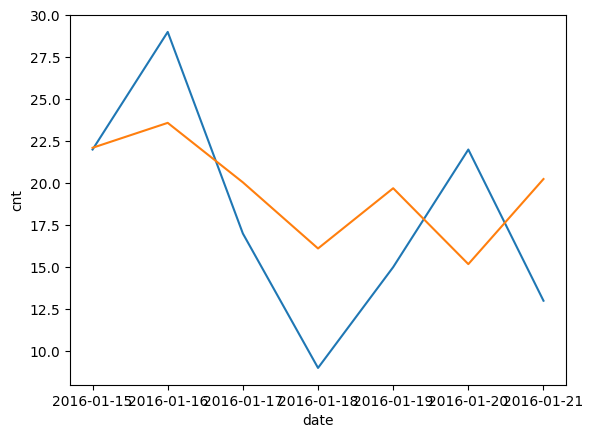

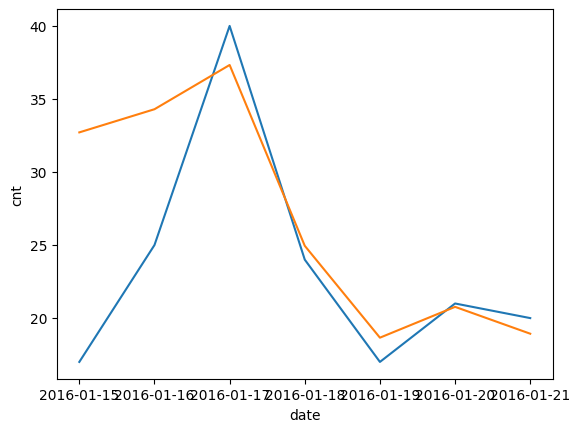

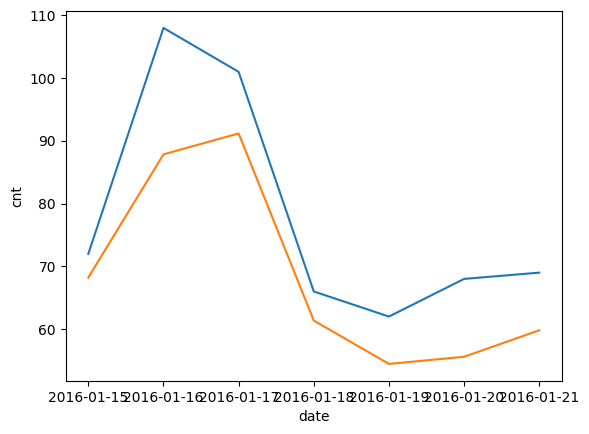

In [167]:
for i, store in enumerate(result['store_id'].unique()):
    data = result[result['store_id']==store]
    data.set_index('date')
    sns.lineplot(data=data,
                 x='date',y='cnt')
    sns.lineplot(data=data,
                 x='date',y='cnt_predict')
    plt.show()